In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pymoo.indicators.hv import HV

In [33]:
from helpers.visualizer import plot_pareto_front
from warren_buffett import WarrenBuffett

In [34]:
from moead import Instance, MOEADAlgorithm, MetricEvaluator, ScalarizingFunctionGenerator
from moead.utils import create_pareto_front

from moead.visualization.individuals import plot_igd_for_generations, get_generations_plot
from moead.visualization.pareto_front import plot_pareto_fronts
from moead.metrics.igd import calculate_igd_for_group


from moead.experiment import read_to_df
from moead.visualization.pareto_front import get_pareto_fronts_plot
from moead.visualization.individuals import show_all_generation_plots
from moead.visualization.igd import show_igd_heatmap

In [ ]:
import os
print(os.path.exists("../res/predictions/predictions3.csv"))
print(os.getcwd())

In [ ]:
preds = pd.read_csv("../res/predictions/predictions3.csv")
preds.set_index("time", inplace=True)

In [35]:
wb = WarrenBuffett(preds, path="../res/assets_bundles/Bundle3")
wsm_pareto_front = wb.make_me_rich()
reference_pareto = [(p, r) for (_, p, r) in wsm_pareto_front[::]]

predictions = np.array(list(wb.get_expected_returns().values()))
cov_matrix = wb.get_covariance_matrix()

instance = Instance(cov_matrix, predictions)
min_risk_solution = min(wsm_pareto_front, key=lambda x: x[1])

     pcost       dcost       gap    pres   dres
 0: -4.4257e+00 -2.7439e+00  8e+01  7e+00  6e+00
 1: -4.8412e-01 -2.6085e+00  2e+00  1e-14  1e-15
 2: -1.2234e+00 -1.7526e+00  5e-01  2e-15  6e-16
 3: -1.7294e+00 -1.7473e+00  2e-02  2e-16  7e-16
 4: -1.7438e+00 -1.7439e+00  2e-04  2e-16  6e-16
 5: -1.7439e+00 -1.7439e+00  2e-06  4e-16  7e-16
 6: -1.7439e+00 -1.7439e+00  2e-08  2e-16  8e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.1900e-04 -1.0004e+00  1e+00  1e-16  5e+00
 1:  2.1865e-04 -1.0443e-02  1e-02  2e-16  5e-02
 2:  1.9468e-04 -4.1967e-04  6e-04  1e-16  3e-03
 3:  1.1660e-04  4.7819e-06  1e-04  5e-17  7e-19
 4:  1.0305e-04  8.2640e-05  2e-05  4e-17  4e-19
 5:  9.8710e-05  9.7158e-05  2e-06  4e-17  4e-19
 6:  9.8511e-05  9.8469e-05  4e-08  7e-17  3e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.7432e-02 -1.0177e+00  1e+00  0e+00  5e+00
 1:  2.6696e-02 -2.3469e-02  5e-02  5e-17  2e-01
 2:  2.3175e-02  1.5938e

In [36]:
# from moead.experiment import run_experiment, read_to_df
# 
# 
# function_numbers = [10, 30, 50, 100]
# generations = [100, 300, 500, 1_000]
# RUN_PER_CONFIG = 20
# 
# kwargs = {
#     "initial_assignment": "greedy",
#     "generate_high_risk_vectors": False,
# }
# 
# run_experiment(instance, function_numbers, generations, RUN_PER_CONFIG, "../res/experiment_results/history5", reference_pareto, kwargs)

In [37]:
ROOT_AFTER_MODIFICATION = '../res/experiment_results/history4'
modification_df = read_to_df(ROOT_AFTER_MODIFICATION)

ROOT_V1 = '../res/experiment_results/history5'
v1_df = read_to_df(ROOT_V1)

In [38]:
modified_grouped_df = modification_df.groupby(['Generation', 'Run_id', 'Scalar_funcs', 'TotalGenerations']).agg(list)
modified_grouped_df.reset_index(inplace=True)

# Apply the calculate_igd_for_group function to each group and assign the result to a new column
modified_grouped_df['IGD'] = modified_grouped_df.apply(lambda x:calculate_igd_for_group(x, reference_pareto), axis=1)

In [39]:
v1_grouped_df = v1_df.groupby(['Generation', 'Run_id', 'Scalar_funcs', 'TotalGenerations']).agg(list)
v1_grouped_df.reset_index(inplace=True)

# Apply the calculate_igd_for_group function to each group and assign the result to a new column
v1_grouped_df['IGD'] = v1_grouped_df.apply(lambda x:calculate_igd_for_group(x, reference_pareto), axis=1)

In [40]:
# Merge the grouped DataFrame back to the original DataFrame based on the grouped columns
modification_df = pd.merge(modification_df, modified_grouped_df, on=['Generation', 'Run_id', 'Scalar_funcs', 'TotalGenerations'], how='left')
modification_df.drop(columns=['Profit_y', 'Risk_y', 'Diversity_y'], inplace=True)
modification_df.rename(columns={'Profit_x': 'Profit', 'Risk_x': 'Risk', 'Diversity_x': 'Diversity'}, inplace=True)
# modification_df

In [41]:
# Merge the grouped DataFrame back v the original DataFrame based on the grouped columns
v1_df = pd.merge(v1_df, v1_grouped_df, on=['Generation', 'Run_id', 'Scalar_funcs', 'TotalGenerations'], how='left')
v1_df.drop(columns=['Profit_y', 'Risk_y', 'Diversity_y'], inplace=True)
v1_df.rename(columns={'Profit_x': 'Profit', 'Risk_x': 'Risk', 'Diversity_x': 'Diversity'}, inplace=True)

In [42]:
modification_df['IGD'] = modification_df['IGD'].astype(float)
modification_df['TotalGenerations'] = modification_df['TotalGenerations'].astype(int)
modification_df['Scalar_funcs'] = modification_df['Scalar_funcs'].astype(int)
modification_df['Generation'] = modification_df['Generation'].astype(int)
modification_df['Run_id'] = modification_df['Run_id'].astype(int)
modification_df['Profit'] = modification_df['Profit'].astype(float)
modification_df['Risk'] = modification_df['Risk'].astype(float)
modification_df['Diversity'] = modification_df['Diversity'].astype(int)

In [43]:
v1_df['IGD'] = v1_df['IGD'].astype(float)
v1_df['TotalGenerations'] = v1_df['TotalGenerations'].astype(int)
v1_df['Scalar_funcs'] = v1_df['Scalar_funcs'].astype(int)
v1_df['Generation'] = v1_df['Generation'].astype(int)
v1_df['Run_id'] = v1_df['Run_id'].astype(int)
v1_df['Profit'] = v1_df['Profit'].astype(float)
v1_df['Risk'] = v1_df['Risk'].astype(float)
v1_df['Diversity'] = v1_df['Diversity'].astype(int)

In [44]:
mean_modification_igd_df = modification_df.groupby(['Generation', 'Scalar_funcs', 'TotalGenerations']).mean().reset_index()
mean_modification_igd_df.drop(columns=['Run_id', 'Profit', 'Risk', 'Diversity'], inplace=True)
mean_modification_igd_df['Generation'] = mean_modification_igd_df['Generation'].astype(int)
mean_modification_igd_df['TotalGenerations'] = mean_modification_igd_df['TotalGenerations'].astype(int)
mean_modification_igd_df['Scalar_funcs'] = mean_modification_igd_df['Scalar_funcs'].astype(int)
mean_modification_igd_df['IGD'] = mean_modification_igd_df['IGD'].astype(float)

In [45]:
mean_v1_df = v1_df.groupby(['Generation', 'Scalar_funcs', 'TotalGenerations']).mean().reset_index()
mean_v1_df.drop(columns=['Run_id', 'Profit', 'Risk', 'Diversity'], inplace=True)
mean_v1_df['Generation'] = mean_v1_df['Generation'].astype(int)
mean_v1_df['TotalGenerations'] = mean_v1_df['TotalGenerations'].astype(int)
mean_v1_df['Scalar_funcs'] = mean_v1_df['Scalar_funcs'].astype(int)
mean_v1_df['IGD'] = mean_v1_df['IGD'].astype(float)

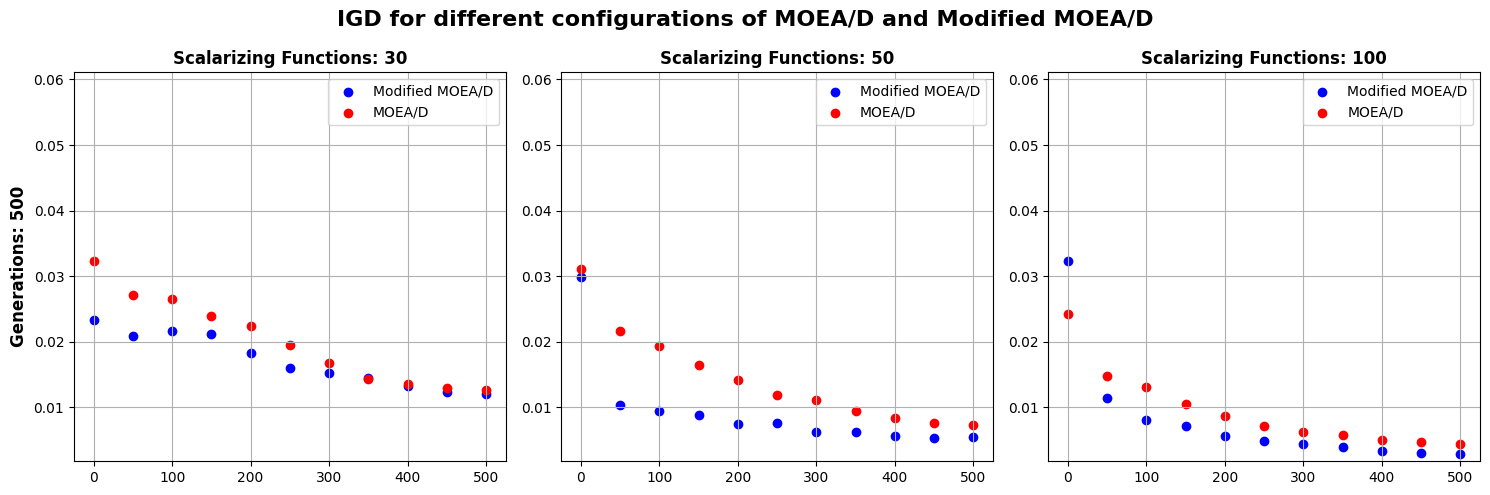

In [75]:
total_gens = [500] #mean_modification_igd_df['TotalGenerations'].nunique()
sc_funcs = [30, 50, 100] #mean_modification_igd_df['Scalar_funcs'].nunique()
igds_fig, axs = plt.subplots(len(total_gens), len(sc_funcs), figsize=(15, 5))

min_igd = np.min([mean_modification_igd_df['IGD'].min(), mean_v1_df['IGD'].min()])
max_igd = np.max([mean_modification_igd_df['IGD'].max(), mean_v1_df['IGD'].max()])

for i, gen in enumerate(total_gens):
    for j, scalar_funcs in enumerate(sc_funcs):
        data1 = mean_modification_igd_df[(mean_modification_igd_df['TotalGenerations'] == gen) & (mean_modification_igd_df['Scalar_funcs'] == scalar_funcs)]
        data2 = mean_v1_df[(mean_v1_df['TotalGenerations'] == gen) & (mean_v1_df['Scalar_funcs'] == scalar_funcs)]
        ax = axs[j]
        # ax = axs[i, j]
        ax.scatter(data1['Generation'], data1['IGD'], label='Modified MOEA/D', color='blue')
        ax.scatter(data2['Generation'], data2['IGD'], label='MOEA/D', color='red')
        ax.set_ylim(min_igd, max_igd)
        if j == 0:
            ax.set_ylabel(f"Generations: {gen}", fontsize=12, fontweight='bold', rotation=90)
        if i == 0:
            ax.set_title(f"Scalarizing Functions: {scalar_funcs}", fontsize=12, fontweight='bold')
        ax.grid(True)
        ax.legend()#
        
# lgd = axs[0].get_legend_handles_labels()
# igds_fig.legend(lgd[0], lgd[1], loc='center right', bbox_to_anchor=(1.11, 0.5), ncol=1)
igds_fig.suptitle('IGD for different configurations of MOEA/D and Modified MOEA/D', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [47]:
# Define a custom aggregation function to calculate the mean of each row across different runs
def mean_row_across_runs(values):
    # print(type(values))
    return np.mean(values.to_list(), axis=0)

In [48]:
# Group by the specified columns and apply the custom aggregation function
modification_df = modification_df.groupby(['Generation', 'Scalar_funcs', 'TotalGenerations', 'Run_id']).agg({
    'Profit': list,
    'Risk': list,
    'Diversity': list
}).reset_index()

modification_df = modification_df.groupby(['Generation', 'Scalar_funcs', 'TotalGenerations']).agg({
    'Profit': mean_row_across_runs,
    'Risk': mean_row_across_runs,
    'Diversity': mean_row_across_runs
}).reset_index()

modification_df = modification_df.explode(['Profit', 'Risk', 'Diversity'])
modification_df.reset_index(inplace=True, drop=True)
modification_df.Generation = modification_df.Generation.astype(int)

In [49]:
# Group by the specified columns and apply the custom aggregation function
v1_df = v1_df.groupby(['Generation', 'Scalar_funcs', 'TotalGenerations', 'Run_id']).agg({
    'Profit': list,
    'Risk': list,
    'Diversity': list
}).reset_index()

v1_df = v1_df.groupby(['Generation', 'Scalar_funcs', 'TotalGenerations']).agg({
    'Profit': mean_row_across_runs,
    'Risk': mean_row_across_runs,
    'Diversity': mean_row_across_runs
}).reset_index()

v1_df = v1_df.explode(['Profit', 'Risk', 'Diversity'])
v1_df.reset_index(inplace=True, drop=True)
v1_df.Generation = v1_df.Generation.astype(int)

In [50]:
modification_df['Scalar_funcs'] = modification_df['Scalar_funcs'].astype(int)
modification_df['TotalGenerations'] = modification_df['TotalGenerations'].astype(int)
modification_df['Generation'] = modification_df['Generation'].astype(int)

modification_df = modification_df.merge(mean_modification_igd_df, on=['Generation', 'Scalar_funcs', 'TotalGenerations'], how='left')
# experiment_df

In [51]:
v1_df['Scalar_funcs'] = v1_df['Scalar_funcs'].astype(int)
v1_df['TotalGenerations'] = v1_df['TotalGenerations'].astype(int)
v1_df['Generation'] = v1_df['Generation'].astype(int)

v1_df = v1_df.merge(mean_v1_df, on=['Generation', 'Scalar_funcs', 'TotalGenerations'], how='left')

In [52]:
for_pareto_modification_df = modification_df.drop(columns = ['IGD'])
for_pareto_modification_df = for_pareto_modification_df.groupby(['Generation', 'Scalar_funcs', 'TotalGenerations']).agg(list)
for_pareto_modification_df['Pareto'] = for_pareto_modification_df.apply(lambda x: list(zip(x['Profit'], x['Risk'])), axis=1)
for_pareto_modification_df.drop(columns=['Profit', 'Risk', 'Diversity'], inplace=True)
for_pareto_modification_df.reset_index(inplace=True)
# for_pareto_df

In [53]:
for_pareto_v1_df = v1_df.drop(columns = ['IGD'])
for_pareto_v1_df = for_pareto_v1_df.groupby(['Generation', 'Scalar_funcs', 'TotalGenerations']).agg(list)
for_pareto_v1_df['Pareto'] = for_pareto_v1_df.apply(lambda x: list(zip(x['Profit'], x['Risk'])), axis=1)
for_pareto_v1_df.drop(columns=['Profit', 'Risk', 'Diversity'], inplace=True)
for_pareto_v1_df.reset_index(inplace=True)

In [54]:
pareto_modif_50_1000 = for_pareto_modification_df[(for_pareto_modification_df['Scalar_funcs'] == 50) & (for_pareto_modification_df['TotalGenerations'] == 1000)]['Pareto'].values[-1]
pareto_modif_100_1000 = for_pareto_modification_df[(for_pareto_modification_df['Scalar_funcs'] == 100) & (for_pareto_modification_df['TotalGenerations'] == 1000)]['Pareto'].values[-1]
pareto_modif_50_100 = for_pareto_modification_df[(for_pareto_modification_df['Scalar_funcs'] == 50) & (for_pareto_modification_df['TotalGenerations'] == 100)]['Pareto'].values[-1]
pareto_modif_100_100 = for_pareto_modification_df[(for_pareto_modification_df['Scalar_funcs'] == 100) & (for_pareto_modification_df['TotalGenerations'] == 100)]['Pareto'].values[-1]

In [55]:
pareto_v1_50_1000 = for_pareto_v1_df[(for_pareto_v1_df['Scalar_funcs'] == 50) & (for_pareto_v1_df['TotalGenerations'] == 1000)]['Pareto'].values[-1]
pareto_v1_100_1000 = for_pareto_v1_df[(for_pareto_v1_df['Scalar_funcs'] == 100) & (for_pareto_v1_df['TotalGenerations'] == 1000)]['Pareto'].values[-1]
pareto_v1_50_100 = for_pareto_v1_df[(for_pareto_v1_df['Scalar_funcs'] == 50) & (for_pareto_v1_df['TotalGenerations'] == 100)]['Pareto'].values[-1]
pareto_v1_100_100 = for_pareto_v1_df[(for_pareto_v1_df['Scalar_funcs'] == 100) & (for_pareto_v1_df['TotalGenerations'] == 100)]['Pareto'].values[-1]

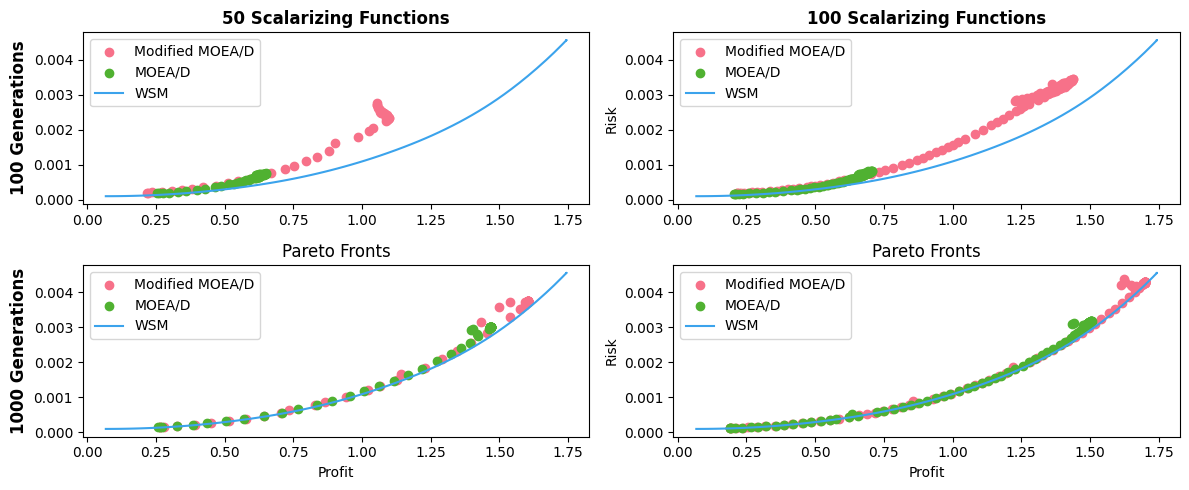

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(12, 5))
labels = ['Modified MOEA/D', 'MOEA/D']

# get_pareto_fronts_plot([pareto_50_1000, pareto_100_1000], ax = ax, algorithm_params={'Number of Scalarizing Functions': 50}, reference_pareto=reference_pareto, labels=labels)

get_pareto_fronts_plot([pareto_modif_50_100, pareto_v1_50_100], ax=axs[0, 0], reference_pareto=reference_pareto, labels=labels, ref_pareto_label='WSM')
get_pareto_fronts_plot([pareto_modif_100_100, pareto_v1_100_100], ax=axs[0, 1], reference_pareto=reference_pareto, labels=labels, ref_pareto_label='WSM')
get_pareto_fronts_plot([pareto_modif_50_1000, pareto_v1_50_1000], ax=axs[1, 0], reference_pareto=reference_pareto, labels=labels, ref_pareto_label='WSM')
get_pareto_fronts_plot([pareto_modif_100_1000, pareto_v1_100_1000], ax=axs[1, 1], reference_pareto=reference_pareto, labels=labels, ref_pareto_label='WSM')
axs[1,0].set_xlabel('Profit')
axs[1,1].set_xlabel('Profit')
axs[0, 1].set_ylabel('Risk')
axs[1, 1].set_ylabel('Risk')

axs[0, 0].set_title('50 Scalarizing Functions', fontsize=12, fontweight='bold')
axs[0, 1].set_title('100 Scalarizing Functions', fontsize=12, fontweight='bold')

axs[0, 0].set_ylabel('100 Generations', fontsize=12, fontweight='bold')
axs[1, 0].set_ylabel('1000 Generations', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

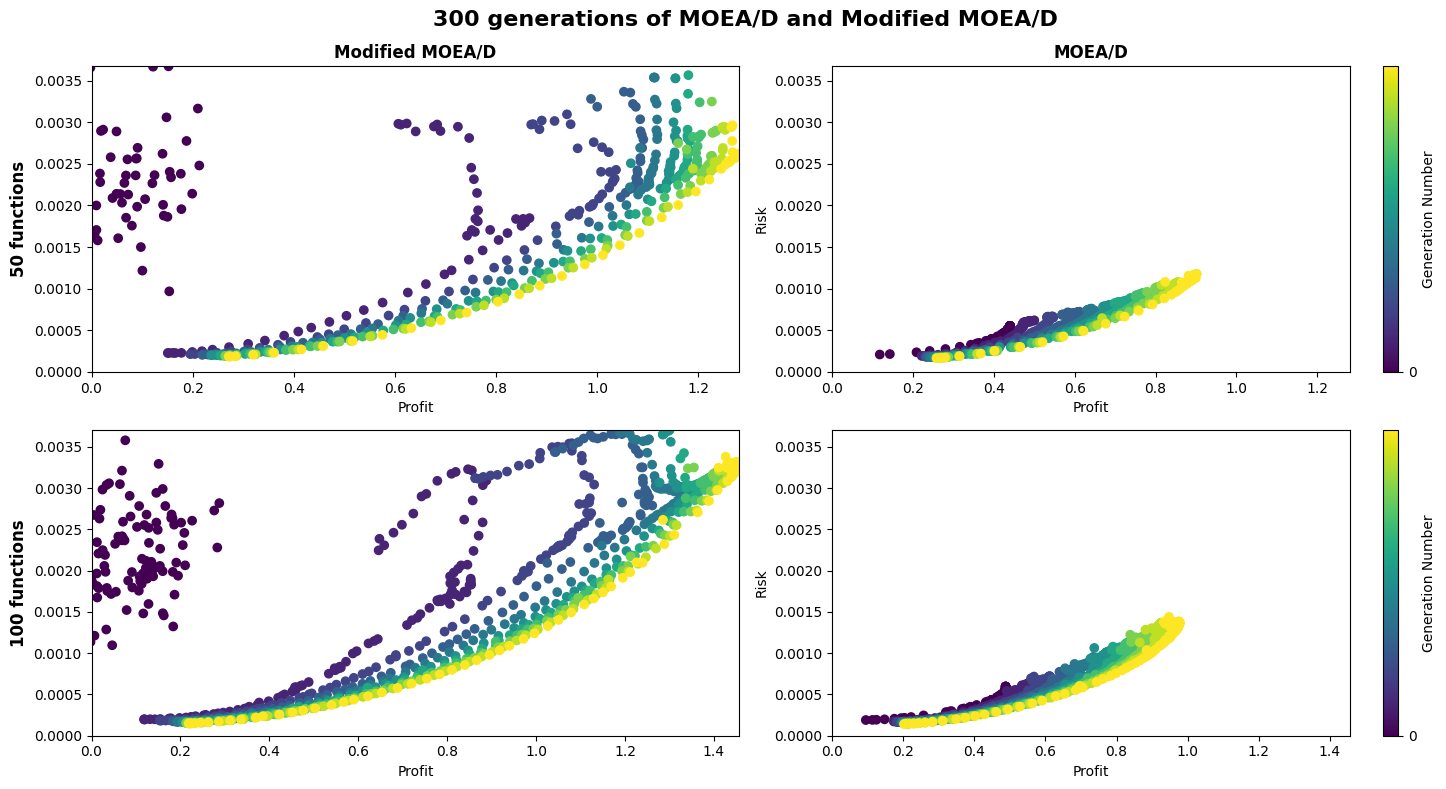

In [57]:
generations = 300
funcs = [50, 100]
popul_fig, axs = plt.subplots(len(funcs), 2, figsize=(15, 8))


for j, scalar_funcs in enumerate(sorted(funcs)):
    data_modif = modification_df[(modification_df['TotalGenerations'] == generations) & (modification_df['Scalar_funcs'] == scalar_funcs)]
    data_v1 = v1_df[(v1_df['TotalGenerations'] == generations) & (v1_df['Scalar_funcs'] == scalar_funcs)]
    
    max_profit = np.max([data_modif['Profit'].max(), data_v1['Profit'].max()])
    max_risk = np.max([data_modif['Risk'].max(), data_v1['Risk'].max()])
    
    ax = axs[j, 0]
    ax, cbar0 = get_generations_plot(data_modif, ax=ax, num_scalar_funcs=scalar_funcs, xlim=(0, max_profit), ylim=(0, max_risk))
    cbar0.remove()
    ax.get_legend().remove()
    
    ax = axs[j, 1]
    ax, cbar1 = get_generations_plot(data_v1, ax=ax, num_scalar_funcs=scalar_funcs, xlim=(0, max_profit), ylim=(0, max_risk))
    ax.get_legend().remove()
        
axs[0, 0].set_title('Modified MOEA/D', fontsize=12, fontweight='bold')
axs[0, 1].set_title('MOEA/D', fontsize=12, fontweight='bold')

for i, f in enumerate(funcs):
    axs[i, 0].set_ylabel(f"{f} functions", fontsize=12, fontweight='bold', rotation=90)
    
plt.suptitle('300 generations of MOEA/D and Modified MOEA/D', fontsize=16, fontweight='bold')
    
plt.tight_layout()
plt.show()

In [58]:
# show_all_generation_plots(modification_df)

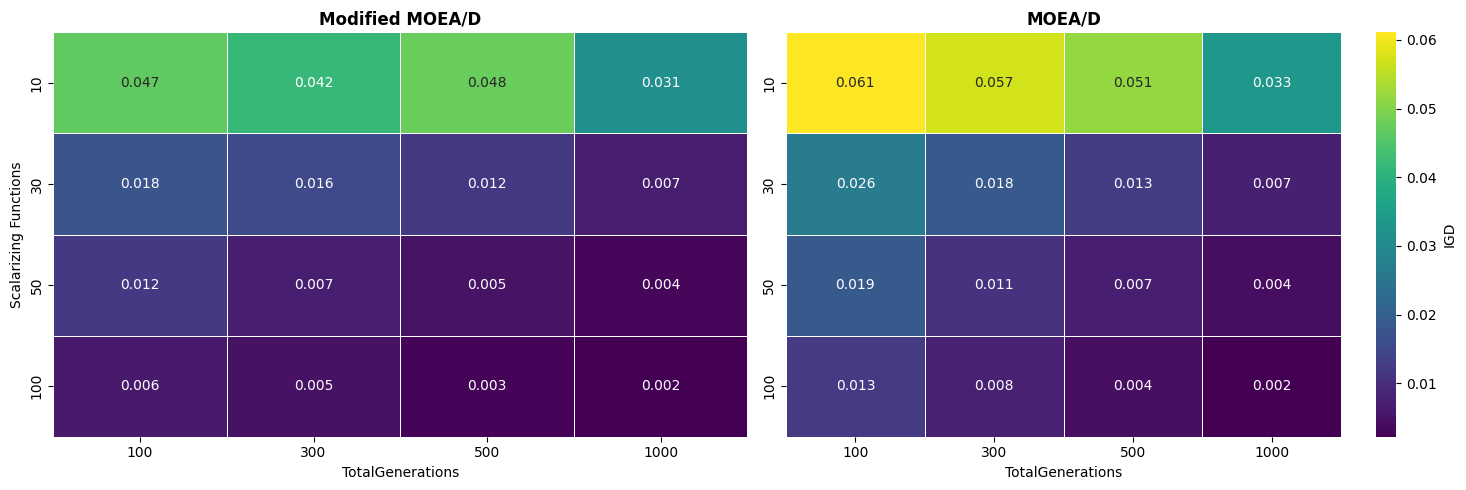

In [65]:
heatmap_igd_fig, axs = plt.subplots(1, 2, figsize=(15, 5))

max_igd = np.max([modification_df['IGD'].max(), v1_df['IGD'].max()])
show_igd_heatmap(modification_df,axs[0], vmax=max_igd, colorbar=False)
show_igd_heatmap(v1_df, axs[1], vmax=max_igd)

axs[0].set_title('Modified MOEA/D', fontsize=12, fontweight='bold')
axs[1].set_title('MOEA/D', fontsize=12, fontweight='bold')

axs[1].set_ylabel(None)

plt.tight_layout()
plt.show()